<a href="https://colab.research.google.com/github/thetrotfreak/MCA572/blob/main/2347111_NNDL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Dataset Overview:

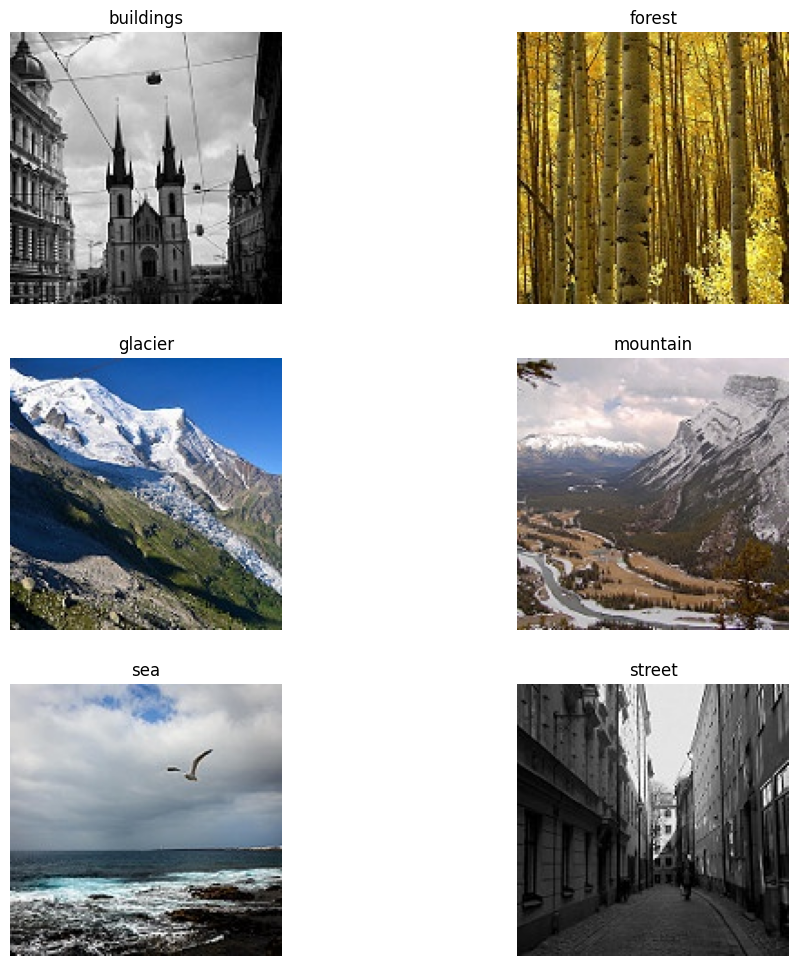

In [ ]:
import matplotlib.pyplot as plt
import os
import cv2

train_dir = 'seg_train/seg_train/'

# Define classes
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

# Plot a few images
def plot_samples(train_dir, classes):
    plt.figure(figsize=(12, 12))
    for idx, category in enumerate(classes):
        folder = os.path.join(train_dir, category)
        file = os.listdir(folder)[0]  # Load the first image from each class
        image = cv2.imread(os.path.join(folder, file))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 2, idx+1)
        plt.imshow(image)
        plt.title(category)
        plt.axis('off')

plot_samples(train_dir, classes)
plt.show()


## Model Architecture:

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

# Flattening the output and adding fully connected layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 74, 74, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                      

## Model Training:

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Image augmentation for training with validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Normalize pixel values to [0,1]
    rotation_range=40,             # Randomly rotate images in the range
    width_shift_range=0.2,         # Randomly translate images horizontally
    height_shift_range=0.2,        # Randomly translate images vertically
    shear_range=0.2,               # Randomly shear images
    zoom_range=0.2,                # Randomly zoom into images
    horizontal_flip=True,          # Randomly flip images horizontally
    fill_mode='nearest',           # Fill missing pixels after transformation
    validation_split=0.2           # Split the data for validation
)

# Load the train and validation data from the directory
train_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train/',
    target_size=(128, 128),       # Reduce image size to 128x128 for faster training
    batch_size=32,
    class_mode='categorical',
    subset='training'             # 80% data for training
)

validation_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train/',
    target_size=(128, 128),       # Same image size for validation
    batch_size=32,
    class_mode='categorical',
    subset='validation'           # 20% data for validation
)

# Use pre-trained VGG16 model and fine-tune the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model to prevent retraining

# Add custom classification head
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),   # Dense layer with 256 units
    layers.Dropout(0.5),                    # Dropout layer for regularization
    layers.Dense(6, activation='softmax')   # Final layer with 6 output categories
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=10,  # Start with 10 epochs and monitor performance
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[early_stopping]  # Stop training when validation loss doesn't improve
)

# Save the trained model
model.save('intel_image_classification_model.h5')

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {val_accuracy:.4f}, Validation Loss: {val_loss:.4f}')


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Epoch 1/10
350/350 [==============================] - 108s 305ms/step - loss: 0.8140 - accuracy: 0.6942 - val_loss: 0.5473 - val_accuracy: 0.7945
Epoch 2/10
350/350 [==============================] - 107s 306ms/step - loss: 0.6540 - accuracy: 0.7575 - val_loss: 0.5191 - val_accuracy: 0.8014
Epoch 3/10
350/350 [==============================] - 107s 304ms/step - loss: 0.6088 - accuracy: 0.7719 - val_loss: 0.5597 - val_accuracy: 0.7841
Epoch 4/10
350/350 [==============================] - 106s 301ms/step - loss: 0.5915 - accuracy: 0.7768 - val_loss: 0.4878 - val_accuracy: 0.8179
Epoch 5/10
350/350 [==============================] - 107s 306ms/step - loss: 0.5866 - accuracy: 0.7824 - val_loss: 0.4937 - val_accuracy: 0.8129
Epoch 6/10
350/350 [==============================] - 106s 304ms/step - loss: 0.5762 - accuracy: 0.7896 - val_loss: 0.4878 - val_accuracy: 0.8157
Epoch 7/10
350/350 [===================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


88/88 [==============================] - 21s 238ms/step - loss: 0.4653 - accuracy: 0.8327
Validation Accuracy: 0.8327, Validation Loss: 0.4653


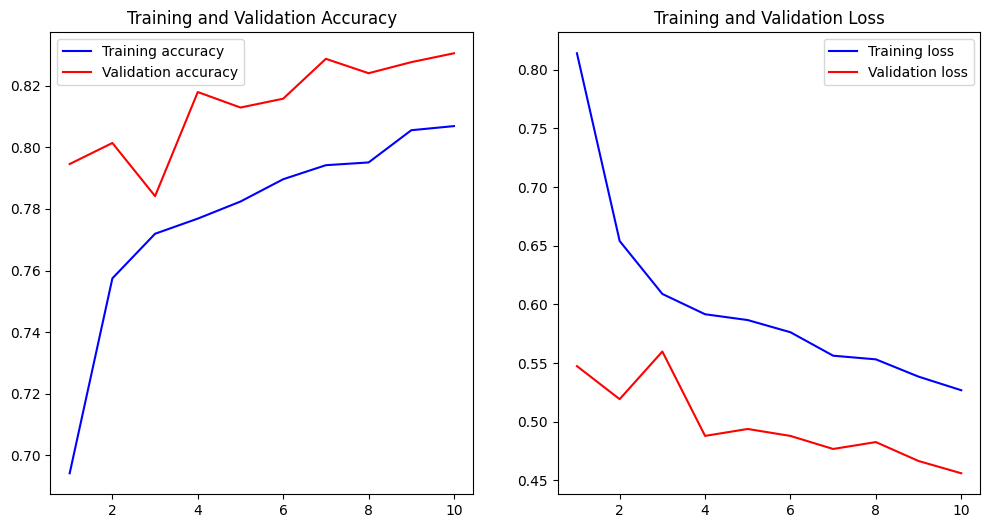

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Evaluation:

88/88 [==============================] - 22s 243ms/step


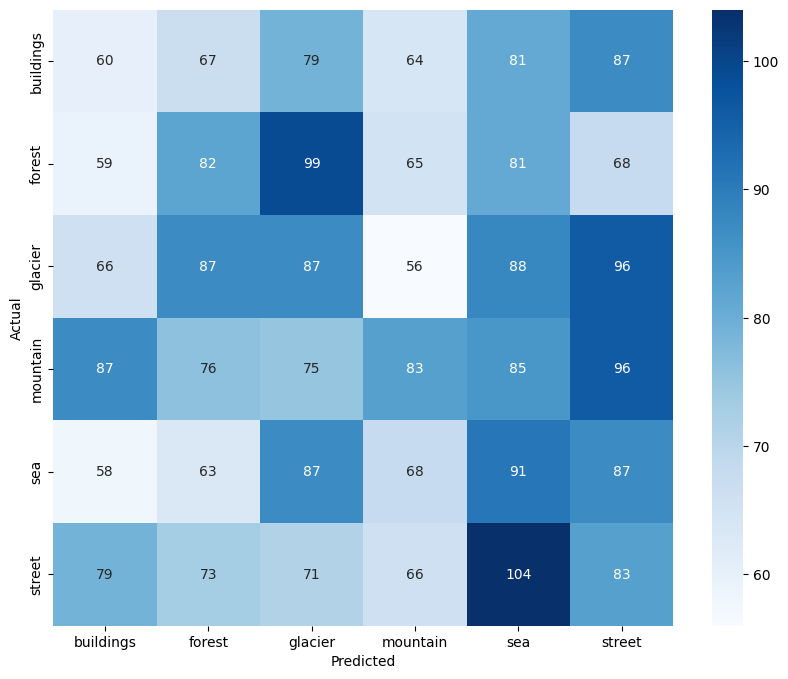

              precision    recall  f1-score   support

   buildings       0.15      0.14      0.14       438
      forest       0.18      0.18      0.18       454
     glacier       0.17      0.18      0.18       480
    mountain       0.21      0.17      0.18       502
         sea       0.17      0.20      0.18       454
      street       0.16      0.17      0.17       476

    accuracy                           0.17      2804
   macro avg       0.17      0.17      0.17      2804
weighted avg       0.17      0.17      0.17      2804



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns

# Make predictions on validation set
val_labels = validation_generator.classes
val_preds = model.predict(validation_generator)
val_preds = np.argmax(val_preds, axis=1)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print(classification_report(val_labels, val_preds, target_names=classes))

## Optimization :

In [ ]:
# Additional augmentations (flipping, zooming, etc.)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Keep validation split for validation data
)

# Define training and validation data generators
train_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training'  # Use training set
)

validation_generator = train_datagen.flow_from_directory(
    'seg_train/seg_train/',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use validation set
)

# Import the ReduceLROnPlateau callback for learning rate fine-tuning
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Create a ReduceLROnPlateau callback to lower the learning rate when a plateau is reached
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # Monitor the validation loss
    factor=0.2,             # Reduce the learning rate by a factor of 0.2
    patience=3,             # Wait for 3 epochs with no improvement before reducing LR
    min_lr=0.00001          # Set a lower bound for the learning rate
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the ReduceLROnPlateau callback
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // 32,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // 32,
    callbacks=[reduce_lr]  # Include ReduceLROnPlateau for learning rate adjustment
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Epoch 1/5
350/350 [==============================] - 135s 384ms/step - loss: 0.5286 - accuracy: 0.8082 - val_loss: 0.4652 - val_accuracy: 0.8272 - lr: 0.0010
Epoch 2/5
350/350 [==============================] - 135s 384ms/step - loss: 0.5155 - accuracy: 0.8033 - val_loss: 0.4387 - val_accuracy: 0.8434 - lr: 0.0010
Epoch 3/5
350/350 [==============================] - 134s 383ms/step - loss: 0.5216 - accuracy: 0.8044 - val_loss: 0.4905 - val_accuracy: 0.8175 - lr: 0.0010
Epoch 4/5
350/350 [==============================] - 135s 384ms/step - loss: 0.5040 - accuracy: 0.8151 - val_loss: 0.4383 - val_accuracy: 0.8448 - lr: 0.0010
Epoch 5/5
350/350 [==============================] - 135s 384ms/step - loss: 0.4996 - accuracy: 0.8205 - val_loss: 0.4501 - val_accuracy: 0.8333 - lr: 0.0010


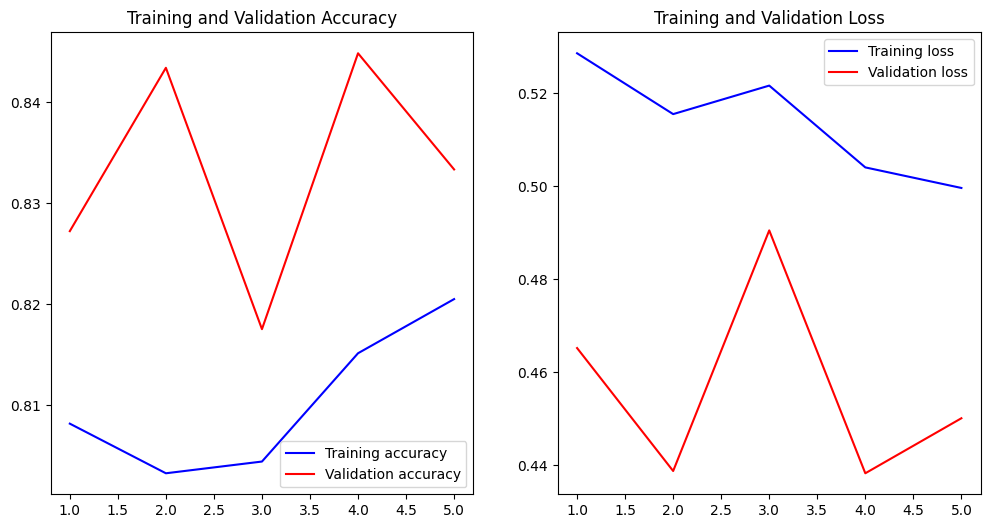

In [ ]:

# Visualize training results
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

88/88 [==============================] - 27s 302ms/step


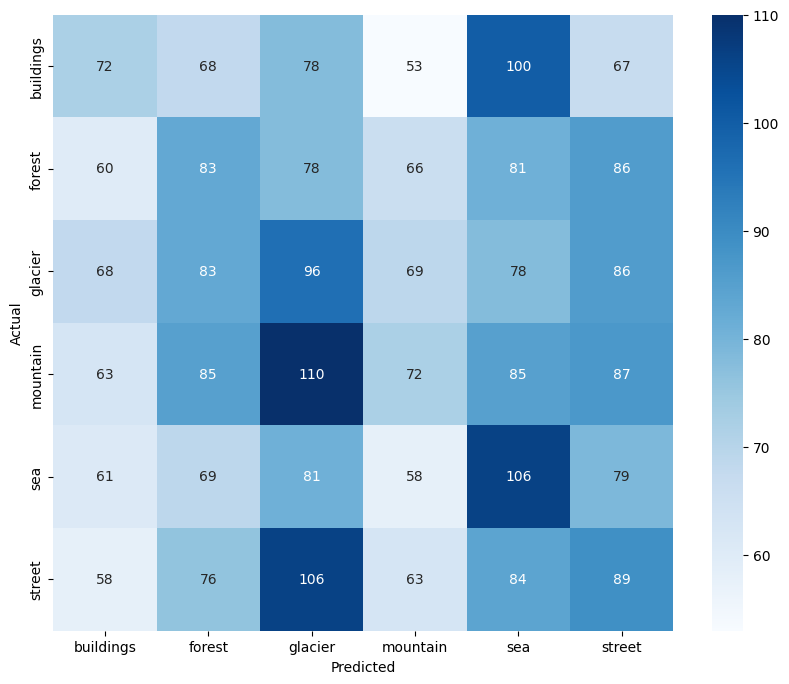

              precision    recall  f1-score   support

   buildings       0.19      0.16      0.18       438
      forest       0.18      0.18      0.18       454
     glacier       0.17      0.20      0.19       480
    mountain       0.19      0.14      0.16       502
         sea       0.20      0.23      0.21       454
      street       0.18      0.19      0.18       476

    accuracy                           0.18      2804
   macro avg       0.18      0.19      0.18      2804
weighted avg       0.18      0.18      0.18      2804



In [ ]:
# Make predictions on validation set
val_labels = validation_generator.classes
val_preds = model.predict(validation_generator)
val_preds = np.argmax(val_preds, axis=1)

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Classification report
print(classification_report(val_labels, val_preds, target_names=classes))